In [11]:
import os
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from scipy.signal import find_peaks

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

% matplotlib inline


In [2]:
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'
data_dir


PosixPath('/Users/lucyxu/PycharmProjects/datasets/phase-2')

In [3]:
image_paths = list(data_dir.glob('00008026.jpg'))
image_path = image_paths[0]

image_path.name


'00008026.jpg'

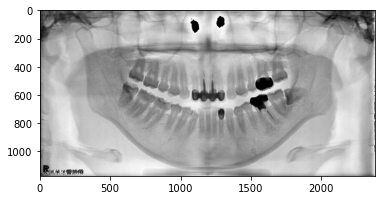

In [4]:
import cv2 as cv

im = cv.imread(str(image_path), cv.IMREAD_GRAYSCALE)

plt.gray()
plt.imshow(1 - im)
plt.show()


In [5]:
import json

json_path = image_path.with_suffix('.json')

target_list = [''.join(i) for i in zip('11223344', '37' * 4)]
with open(json_path, 'r') as f:
    labels = json.load(f)
    labels.pop('imageData', None)

teeth_label = list(filter(lambda item: item['label'] in target_list, labels['shapes']))
teeth_label


[{'label': '13',
  'points': [[973.3030303030303, 334.57575757575756],
   [1070.2727272727273, 645.1818181818181]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': '23',
  'points': [[1303.6060606060605, 355.78787878787875],
   [1397.5454545454545, 645.1818181818181]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': '33',
  'points': [[1302.090909090909, 678.5151515151515],
   [1402.090909090909, 928.5151515151515]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': '43',
  'points': [[1136.939393939394, 693.6666666666666],
   [1023.3030303030303, 925.4848484848485]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': '17',
  'points': [[623.3030303030303, 283.06060606060606],
   [747.5454545454545, 528.5151515151515]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': '27',
  'points': [[1635.4242424242423, 295.1818181818182],
   [1768.7575757575758, 516

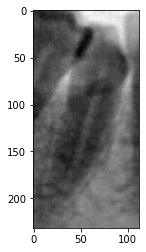

In [59]:
tooth_im_dict = {}
tooth_xyxy_dict = {}

for tooth_label in teeth_label:
    points = tooth_label['points']
    points = list(map(lambda point: list(map(int, point)), points))

    [x1, y1], [x2, y2] = points
    x1, x2 = min(x1, x2), max(x1, x2)
    y1, y2 = min(y1, y2), max(y1, y2)

    tooth_im = im[y1:y2, x1:x2]

    tooth_im_dict[tooth_label['label']] = tooth_im
    tooth_xyxy_dict[tooth_label['label']] = np.array([x1, y1, x2, y2])

tooth_number = '43'
tooth_im = tooth_im_dict[tooth_number]
tooth_xyxy = tooth_xyxy_dict[tooth_number]
plt.imshow(1 - tooth_im)
plt.show()


# Experiment

## get_gap_by_tooth

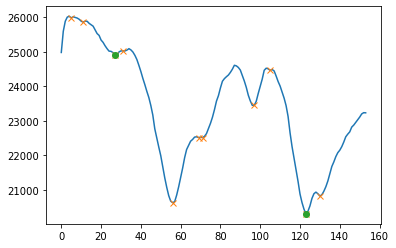

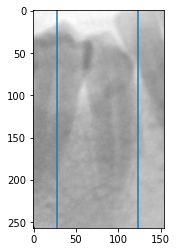

In [60]:
from utils.edge import integral_intensity_projection
import numpy as np
from scipy.ndimage import rotate
from scipy import special
from utils.edge import fill_rotate

theta = 20
s, c = special.sindg(theta), special.cosdg(theta)

tooth_im_rotated = fill_rotate(im, tooth_xyxy, 20)
# tooth_im_rotated = rotate(tooth_im, theta)

h_0, w_0 = tooth_im.shape
h, w = tooth_im_rotated.shape

a = h_0 * s
b = h_0 * c
c = int(w // 2 / b * a)

tooth_im_rotated = tooth_im_rotated[:, :-c]

h, w = tooth_im_rotated.shape


hor, ver = integral_intensity_projection(tooth_im_rotated)
ver_inverse = ver.max() - ver

peaks, properties = find_peaks(ver_inverse, height=0)

peaks_left = peaks[peaks < w / 4]
peaks_right = peaks[peaks > w / 4 * 3]

peaks_lowest = np.array((peaks_left[ver[peaks_left].argmin()], peaks_right[ver[peaks_right].argmin()]))

plt.plot(ver)
plt.plot(peaks, ver[peaks], "x")
plt.plot(peaks_lowest, ver[peaks_lowest], "o")
plt.show()

plt.imshow(1 - tooth_im_rotated)
plt.axvline(peaks_lowest[0])
plt.axvline(peaks_lowest[1])
# plt.axvline(w / 4)
# plt.axvline(w / 4 * 3)
plt.show()


41.49260670634707


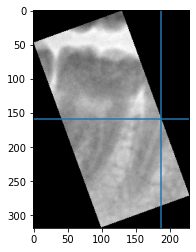

In [52]:
theta = 20
s, c = special.sindg(theta), special.cosdg(theta)

# tooth_im_rotated = fill_rotate(im, tooth_xyxy, 20)
tooth_im_rotated = rotate(tooth_im, theta)

h_0, w_0 = tooth_im.shape
h, w = tooth_im_rotated.shape

a = h_0 * s
b = h_0 * c
c = w // 2 / b * a

print(c)

plt.imshow(1 - tooth_im_rotated)
plt.axvline(w - c)
plt.axhline(h // 2)
plt.show()


<ipython-input-8-882914cc6660>:24: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-8-882914cc6660>:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


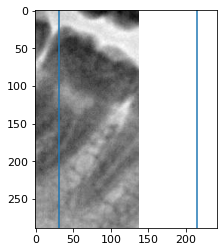

In [8]:
def get_gap_by_tooth(tooth_im):
    h, w = tooth_im.shape

    hor, ver = integral_intensity_projection(tooth_im)
    ver_inverse = ver.max() - ver

    peaks, properties = find_peaks(ver_inverse, height=0)
    # peaks, properties = find_peaks(ver, height=0)

    peaks_left = peaks[peaks < w / 4]
    peaks_right = peaks[peaks > w / 4 * 3]

    peaks_lowest = np.array((peaks_left[ver[peaks_left].argmin()], peaks_right[ver[peaks_right].argmin()]))

    return peaks_lowest


peaks_lowest = get_gap_by_tooth(tooth_im_rotated)
hor, ver = integral_intensity_projection(tooth_im_rotated)

plt.plot(ver)
plt.plot(peaks, ver[peaks], "x")
plt.plot(peaks_lowest, ver[peaks_lowest], "o")
plt.show()

plt.imshow(1 - tooth_im)
plt.axvline(peaks_lowest[0])
plt.axvline(peaks_lowest[1])
plt.show()
